<a href="https://colab.research.google.com/github/krrish4666/Skin-Lesion-Classification-GradCAM/blob/main/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('⚠️ GPU device not found. Go to Runtime > Change runtime type > Set "Hardware accelerator" to GPU.')
else:
    print(f'✅ GPU device found: {device_name}')


✅ GPU device found: /device:GPU:0


In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Image handling
import cv2
from PIL import Image

# Others
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries successfully imported.")


✅ All libraries successfully imported.


In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed()
print("🔒 Seed set for reproducibility.")


🔒 Seed set for reproducibility.


In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krrishrx4666","key":"7838539cc8c661b708f42d90d50bf0fa"}'}

In [ ]:
# Move kaggle.json to correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle CLI
!pip install -q kaggle

# Download HAM10000 dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [01:52<00:00, 12.3MB/s]
100% 5.20G/5.20G [01:52<00:00, 49.5MB/s]


In [ ]:
# Unzip the dataset
!unzip -q skin-cancer-mnist-ham10000.zip -d skin_cancer_data

print("✅ Dataset extracted to /content/skin_cancer_data")


✅ Dataset extracted to /content/skin_cancer_data


In [ ]:
!rm -r skin_cancer_data/ham10000_images_part_1
!rm -r skin_cancer_data/ham10000_images_part_2


In [ ]:
from glob import glob
import os

# New image directory path
image_dir = 'skin_cancer_data/'

# Load metadata
df = pd.read_csv(image_dir + 'HAM10000_metadata.csv')

# Update image paths
df['path'] = df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))


In [ ]:
import glob

# Find all .jpg files in all subdirectories
image_files = glob.glob('skin_cancer_data/**/*.jpg', recursive=True)

print(f"🔍 Found {len(image_files)} image files.")
print("🔗 Example path:", image_files[0])


🔍 Found 10015 image files.
🔗 Example path: skin_cancer_data/HAM10000_images_part_2/ISIC_0031433.jpg


In [ ]:
import os

# image_id = filename without .jpg
image_path_map = {os.path.splitext(os.path.basename(p))[0]: p for p in image_files}

# Assign valid paths to dataframe
df['path'] = df['image_id'].map(image_path_map)

# Confirm mapping worked
print("✅ Mapped paths:", df['path'].apply(os.path.exists).sum(), "/", len(df))
df[['image_id', 'path']].head()


✅ Mapped paths: 10015 / 10015


,image_id,path
0,ISIC_0027419,skin_cancer_data/HAM10000_images_part_1/ISIC_0...
1,ISIC_0025030,skin_cancer_data/HAM10000_images_part_1/ISIC_0...
2,ISIC_0026769,skin_cancer_data/HAM10000_images_part_1/ISIC_0...
3,ISIC_0025661,skin_cancer_data/HAM10000_images_part_1/ISIC_0...
4,ISIC_0031633,skin_cancer_data/HAM10000_images_part_2/ISIC_0...


Model Building (EfficientNet with Transfer Learning)

In [ ]:
IMG_SIZE = 224  # Standard input size for both models
BATCH_SIZE = 16
NUM_CLASSES = 7  # For HAM10000


model_choice = 'efficientnet'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 80/20 split
)
# Add this to ensure 'label' column exists
label_map = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesion'
}
df['label'] = df['dx'].map(label_map)

# Confirm it works
print(df[['dx', 'label']].head())

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)



    dx             label
0  bkl  Benign Keratosis
1  bkl  Benign Keratosis
2  bkl  Benign Keratosis
3  bkl  Benign Keratosis
4  bkl  Benign Keratosis
Found 8012 validated image filenames belonging to 7 classes.
Found 10015 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam


def focal_loss(alpha=0.25, gamma=2.0):
    def focal(y_true, y_pred):
        epsilon = 1e-9
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = tf.reduce_sum(weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return focal

# Define input shape
input_shape = (224, 224, 3)

# Base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = True  # Fine-tune all layers

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)  # 7 classes in HAM10000

# Build model
model = Model(inputs=base_model.input, outputs=outputs)

# 🔥 Compile with Focal Loss
model.compile(optimizer=Adam(1e-5), loss=focal_loss(alpha=0.25, gamma=2.0), metrics=['accuracy'])

# Summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_classes = train_generator.classes  # only from training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weights = dict(enumerate(class_weights))
aggressive_weights = {cls: weight**1.5 for cls, weight in class_weights.items()}


In [ ]:
base_model.trainable = True  # unfreeze if it was frozen

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss=(focal_loss(alpha=0.25, gamma=2.0)),
    metrics=['accuracy']
)


In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


Balance data prep

In [ ]:
from sklearn.utils import resample

TARGET_SAMPLES = 1099  # adjust as needed
resampled_dfs = []

for label in df_train['label'].unique():
    df_class = df_train[df_train['label'] == label]

    if len(df_class) < TARGET_SAMPLES:
        df_resampled = resample(df_class, replace=True, n_samples=TARGET_SAMPLES, random_state=42)
    else:
        df_resampled = df_class.sample(TARGET_SAMPLES, random_state=42)

    resampled_dfs.append(df_resampled)

df_train_balanced = pd.concat(resampled_dfs).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Train generator from oversampled data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_balanced,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Validation generator from untouched validation data
val_generator = train_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 7693 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save every epoch
checkpoint_cb = ModelCheckpoint(
    "model_epoch_{epoch:02d}.h5",
    save_freq='epoch',
    verbose=1
)

# Save best model (by val_loss)
best_checkpoint_cb = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# Early stopping
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Optional manual periodic backups
class SaveEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, save_freq=3):
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(f"backup_epoch_{epoch+1}.h5")
            print(f"🔒 Backup saved at epoch {epoch+1}")

# ✅ Train the model (REMOVE class_weight if oversampling is used)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint_cb, best_checkpoint_cb, earlystop_cb, SaveEveryNEpochs(3)]
)

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.1765 - loss: 0.3762
Epoch 1: saving model to model_epoch_01.h5



Epoch 1: val_loss improved from inf to 0.51076, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 279s 944ms/step - accuracy: 0.1766 - loss: 0.3761 - val_accuracy: 0.0864 - val_loss: 0.5108
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.2802 - loss: 0.3241
Epoch 2: saving model to model_epoch_02.h5



Epoch 2: val_loss did not improve from 0.51076
219/219 ━━━━━━━━━━━━━━━━━━━━ 165s 753ms/step - accuracy: 0.2804 - loss: 0.3240 - val_accuracy: 0.0929 - val_loss: 1.1039
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.3706 - loss: 0.2846
Epoch 3: saving model to model_epoch_03.h5



Epoch 3: val_loss improved from 0.51076 to 0.37848, saving model to best_model.h5


🔒 Backup saved at epoch 3
219/219 ━━━━━━━━━━━━━━━━━━━━ 160s 732ms/step - accuracy: 0.3707 - loss: 0.2846 - val_accuracy: 0.0519 - val_loss: 0.3785
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.4481 - loss: 0.2479
Epoch 4: saving model to model_epoch_04.h5



Epoch 4: val_loss did not improve from 0.37848
219/219 ━━━━━━━━━━━━━━━━━━━━ 160s 732ms/step - accuracy: 0.4482 - loss: 0.2478 - val_accuracy: 0.0599 - val_loss: 0.5410
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.4955 - loss: 0.2177
Epoch 5: saving model to model_epoch_05.h5



Epoch 5: val_loss improved from 0.37848 to 0.37476, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 159s 724ms/step - accuracy: 0.4956 - loss: 0.2177 - val_accuracy: 0.0724 - val_loss: 0.3748
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.5405 - loss: 0.1927
Epoch 6: saving model to model_epoch_06.h5



Epoch 6: val_loss did not improve from 0.37476


🔒 Backup saved at epoch 6
219/219 ━━━━━━━━━━━━━━━━━━━━ 157s 716ms/step - accuracy: 0.5406 - loss: 0.1926 - val_accuracy: 0.0679 - val_loss: 0.3834
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.5811 - loss: 0.1691
Epoch 7: saving model to model_epoch_07.h5



Epoch 7: val_loss improved from 0.37476 to 0.34776, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 159s 728ms/step - accuracy: 0.5811 - loss: 0.1691 - val_accuracy: 0.1358 - val_loss: 0.3478
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6068 - loss: 0.1589
Epoch 8: saving model to model_epoch_08.h5



Epoch 8: val_loss did not improve from 0.34776
219/219 ━━━━━━━━━━━━━━━━━━━━ 159s 725ms/step - accuracy: 0.6068 - loss: 0.1589 - val_accuracy: 0.0959 - val_loss: 0.3608
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6414 - loss: 0.1416
Epoch 9: saving model to model_epoch_09.h5



Epoch 9: val_loss improved from 0.34776 to 0.34136, saving model to best_model.h5


🔒 Backup saved at epoch 9
219/219 ━━━━━━━━━━━━━━━━━━━━ 160s 729ms/step - accuracy: 0.6414 - loss: 0.1416 - val_accuracy: 0.1563 - val_loss: 0.3414
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.6625 - loss: 0.1321
Epoch 10: saving model to model_epoch_10.h5



Epoch 10: val_loss improved from 0.34136 to 0.31335, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 160s 733ms/step - accuracy: 0.6625 - loss: 0.1321 - val_accuracy: 0.2431 - val_loss: 0.3134
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6596 - loss: 0.1289
Epoch 11: saving model to model_epoch_11.h5



Epoch 11: val_loss improved from 0.31335 to 0.30507, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 162s 738ms/step - accuracy: 0.6595 - loss: 0.1289 - val_accuracy: 0.2626 - val_loss: 0.3051
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6878 - loss: 0.1198
Epoch 12: saving model to model_epoch_12.h5



Epoch 12: val_loss improved from 0.30507 to 0.16578, saving model to best_model.h5


🔒 Backup saved at epoch 12
219/219 ━━━━━━━━━━━━━━━━━━━━ 163s 743ms/step - accuracy: 0.6878 - loss: 0.1198 - val_accuracy: 0.6056 - val_loss: 0.1658
Epoch 13/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.6946 - loss: 0.1155
Epoch 13: saving model to model_epoch_13.h5



Epoch 13: val_loss improved from 0.16578 to 0.12354, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 165s 752ms/step - accuracy: 0.6947 - loss: 0.1155 - val_accuracy: 0.6790 - val_loss: 0.1235
Epoch 14/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7037 - loss: 0.1102
Epoch 14: saving model to model_epoch_14.h5



Epoch 14: val_loss did not improve from 0.12354
219/219 ━━━━━━━━━━━━━━━━━━━━ 164s 749ms/step - accuracy: 0.7037 - loss: 0.1102 - val_accuracy: 0.6930 - val_loss: 0.1253
Epoch 15/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.7207 - loss: 0.1030
Epoch 15: saving model to model_epoch_15.h5



Epoch 15: val_loss did not improve from 0.12354


🔒 Backup saved at epoch 15
219/219 ━━━━━━━━━━━━━━━━━━━━ 165s 753ms/step - accuracy: 0.7207 - loss: 0.1030 - val_accuracy: 0.4643 - val_loss: 0.2454
Epoch 16/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.7312 - loss: 0.0961
Epoch 16: saving model to model_epoch_16.h5



Epoch 16: val_loss did not improve from 0.12354
219/219 ━━━━━━━━━━━━━━━━━━━━ 166s 757ms/step - accuracy: 0.7312 - loss: 0.0961 - val_accuracy: 0.4813 - val_loss: 0.2183
Epoch 17/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7337 - loss: 0.0913
Epoch 17: saving model to model_epoch_17.h5



Epoch 17: val_loss improved from 0.12354 to 0.10991, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 170s 777ms/step - accuracy: 0.7337 - loss: 0.0913 - val_accuracy: 0.7249 - val_loss: 0.1099
Epoch 18/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.7437 - loss: 0.0913
Epoch 18: saving model to model_epoch_18.h5



Epoch 18: val_loss did not improve from 0.10991


🔒 Backup saved at epoch 18
219/219 ━━━━━━━━━━━━━━━━━━━━ 173s 788ms/step - accuracy: 0.7437 - loss: 0.0913 - val_accuracy: 0.6525 - val_loss: 0.1265
Epoch 19/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7478 - loss: 0.0849
Epoch 19: saving model to model_epoch_19.h5



Epoch 19: val_loss did not improve from 0.10991
219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 767ms/step - accuracy: 0.7479 - loss: 0.0849 - val_accuracy: 0.6990 - val_loss: 0.1172
Epoch 20/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.7655 - loss: 0.0841
Epoch 20: saving model to model_epoch_20.h5



Epoch 20: val_loss improved from 0.10991 to 0.08533, saving model to best_model.h5


219/219 ━━━━━━━━━━━━━━━━━━━━ 168s 768ms/step - accuracy: 0.7655 - loss: 0.0841 - val_accuracy: 0.7559 - val_loss: 0.0853


In [ ]:
print("Unique labels in generator:", train_generator.class_indices)
print("Unique labels in df:", df['label'].unique())


Unique labels in generator: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Vascular Lesion': 6}
Unique labels in df: ['Benign Keratosis' 'Melanocytic Nevi' 'Dermatofibroma' 'Melanoma'
 'Vascular Lesion' 'Basal Cell Carcinoma' 'Actinic Keratoses']


In [ ]:
print(df_train_balanced[['path', 'label']].sample(5))
assert df_train_balanced['path'].apply(os.path.exists).all()  # All paths must exist


                                                   path                 label
729   skin_cancer_data/HAM10000_images_part_2/ISIC_0...              Melanoma
5362  skin_cancer_data/HAM10000_images_part_2/ISIC_0...     Actinic Keratoses
6192  skin_cancer_data/HAM10000_images_part_2/ISIC_0...  Basal Cell Carcinoma
3851  skin_cancer_data/ham10000_images_part_1/ISIC_0...              Melanoma
1     skin_cancer_data/HAM10000_images_part_2/ISIC_0...              Melanoma


In [ ]:
import shutil
import os

# Create target folder on Drive
target_dir = "/content/drive/MyDrive/skin_lesion_model_checkpoints/"
os.makedirs(target_dir, exist_ok=True)

# Copy all .h5 files (saved checkpoints)
for filename in os.listdir("/content/"):
    if filename.endswith(".h5"):
        shutil.copy(f"/content/{filename}", os.path.join(target_dir, filename))
        print(f"✅ Copied {filename} to Google Drive")


✅ Copied model_epoch_19.h5 to Google Drive
✅ Copied backup_epoch_12.h5 to Google Drive
✅ Copied model_epoch_14.h5 to Google Drive
✅ Copied model_epoch_08.h5 to Google Drive
✅ Copied model_epoch_02.h5 to Google Drive
✅ Copied model_epoch_03.h5 to Google Drive
✅ Copied model_epoch_18.h5 to Google Drive
✅ Copied model_epoch_01.h5 to Google Drive
✅ Copied model_epoch_06.h5 to Google Drive
✅ Copied model_epoch_05.h5 to Google Drive
✅ Copied model_epoch_16.h5 to Google Drive
✅ Copied model_epoch_12.h5 to Google Drive
✅ Copied backup_epoch_3.h5 to Google Drive
✅ Copied model_epoch_07.h5 to Google Drive
✅ Copied model_epoch_09.h5 to Google Drive
✅ Copied backup_epoch_9.h5 to Google Drive
✅ Copied model_epoch_13.h5 to Google Drive
✅ Copied model_epoch_11.h5 to Google Drive
✅ Copied model_epoch_20.h5 to Google Drive
✅ Copied backup_epoch_15.h5 to Google Drive
✅ Copied model_epoch_10.h5 to Google Drive
✅ Copied backup_epoch_18.h5 to Google Drive
✅ Copied model_epoch_04.h5 to Google Drive
✅ Copied

In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/skin_lesion_model_checkpoints/best_model.h5"

model = load_model(model_path, compile=False)  # compile=False avoids warnings


126/126 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step
📊 Classification Report:
                      precision    recall  f1-score   support

   Actinic Keratoses       0.62      0.38      0.48        65
Basal Cell Carcinoma       0.73      0.43      0.54       103
    Benign Keratosis       0.57      0.66      0.61       220
      Dermatofibroma       0.60      0.65      0.62        23
    Melanocytic Nevi       0.90      0.86      0.88      1341
            Melanoma       0.41      0.57      0.47       223
     Vascular Lesion       0.82      0.82      0.82        28

            accuracy                           0.77      2003
           macro avg       0.67      0.63      0.63      2003
        weighted avg       0.79      0.77      0.77      2003



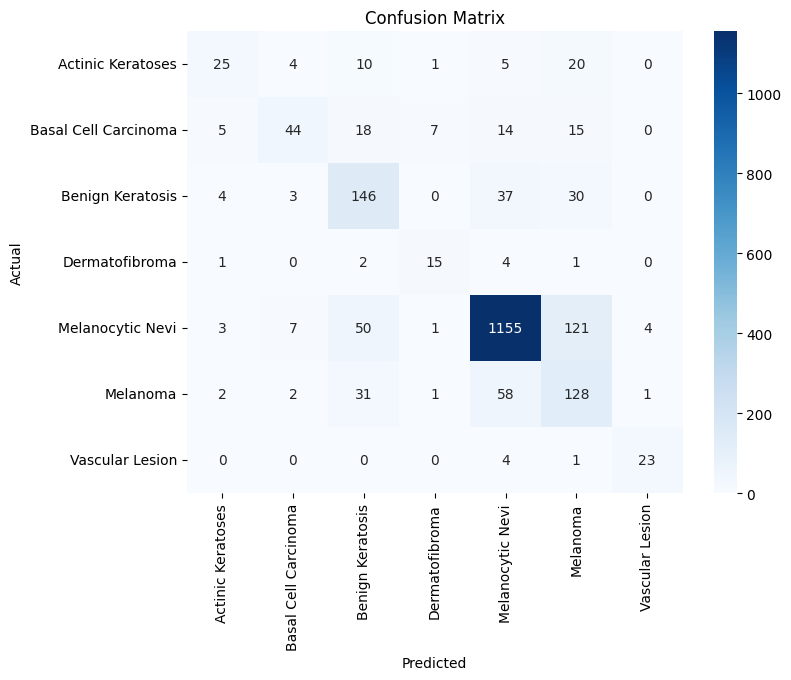

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get true and predicted labels
val_generator.reset()
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = list(val_generator.class_indices.keys())

# Report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(alpha=0.25, gamma=2.0),  # same custom loss you defined
    metrics=['accuracy']
)

val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 364ms/step - accuracy: 0.7720 - loss: 0.0786
Validation Loss: 0.0830
Validation Accuracy: 0.7624


GRAD-CAM EXPLAINABILITY

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal(y_true, y_pred):
        epsilon = 1e-9
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = tf.reduce_sum(weight * cross_entropy, axis=1)
        return tf.reduce_mean(loss)
    return focal

# Re-load model using custom_objects
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/skin_lesion_model_checkpoints/best_model.h5", custom_objects={'focal': focal_loss(alpha=0.25, gamma=2.0)})


In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
for layer in model.layers[::-1]:
    if 'conv' in layer.name:
        print(layer.name)
        break


top_conv


In [ ]:
last_conv_layer_name = "top_conv"  # Replace this if your printed name is different


In [ ]:
from tensorflow.keras.models import Model

grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)


In [ ]:
img = image.load_img("/content/skin_cancer_data/HAM10000_images_part_1/ISIC_0024307.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

print(img_array.shape)  # Should be (1, 224, 224, 3)


(1, 224, 224, 3)


In [ ]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # ensure size matches heatmap

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))  # resize to match image

    # Ensure both are uint8 and same shape
    superimposed_img = cv2.addWeighted(img.astype(np.uint8), 1-alpha, heatmap.astype(np.uint8), alpha, 0)

    # Show
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis("off")
    plt.show()



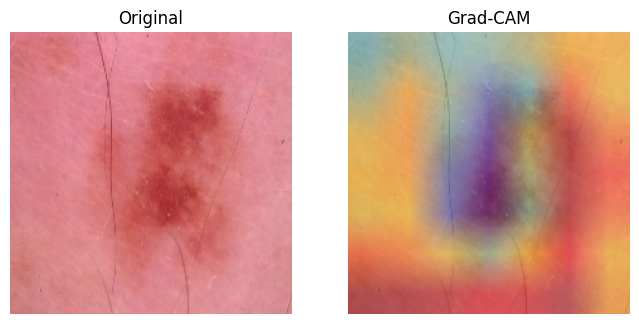

In [ ]:
img_path = "/content/skin_cancer_data/HAM10000_images_part_1/ISIC_0024307.jpg"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display Grad-CAM
display_gradcam(img_path, heatmap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


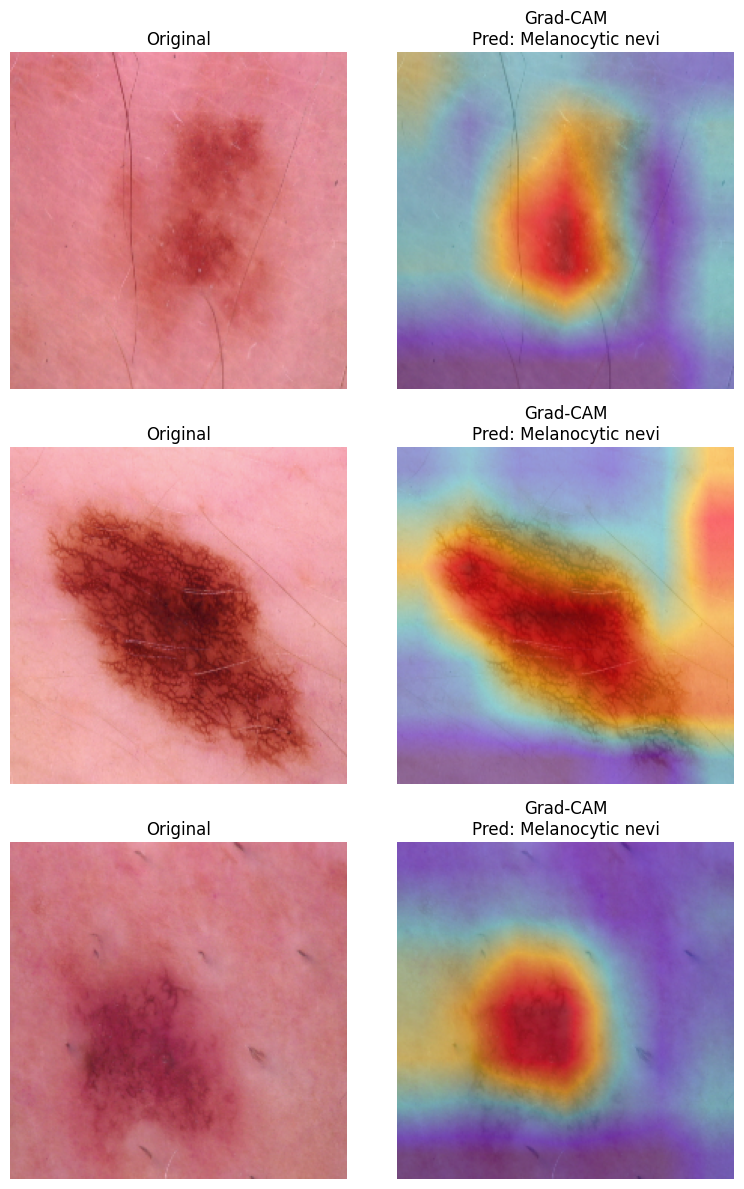

In [58]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Example class names (HAM10000 classes)
class_names = [
    "Actinic keratoses",
    "Basal cell carcinoma",
    "Benign keratosis-like lesions",
    "Dermatofibroma",
    "Melanocytic nevi",
    "Vascular lesions",
    "Melanoma"
]

def get_img_array(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_array = img_resized.astype("float32") / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img_resized

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    jet = cv2.cvtColor(jet, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(jet, alpha, img, 1 - alpha, 0)
    return superimposed_img

# List of image paths
img_paths = [
    "/content/skin_cancer_data/HAM10000_images_part_1/ISIC_0024307.jpg",
    "/content/skin_cancer_data/HAM10000_images_part_1/ISIC_0024308.jpg",
    "/content/skin_cancer_data/HAM10000_images_part_1/ISIC_0024309.jpg"
]

# Plot grid
fig, axes = plt.subplots(len(img_paths), 2, figsize=(8, 4*len(img_paths)))

for i, img_path in enumerate(img_paths):
    img_array, orig_img = get_img_array(img_path)

    # Predict class
    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds)]

    # Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    superimposed_img = display_gradcam(orig_img, heatmap)

    # Original image
    axes[i, 0].imshow(orig_img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Original")

    # Grad-CAM image + predicted label
    axes[i, 1].imshow(superimposed_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Grad-CAM\nPred: {pred_class}")

plt.tight_layout()
plt.show()
